<a href="https://colab.research.google.com/github/armandossfortaleza/testes/blob/main/monitorar_cpu_ram_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install psutil nvidia-ml-py3 gpustat matplotlib pandas

In [2]:
!pip install torch

In [4]:
# %pip install psutil nvidia-ml-py3 gpustat matplotlib torch
import psutil
import pynvml
import time
import threading
import pandas as pd
import numpy as np
import torch
import os
from datetime import datetime

# Initialize NVML for GPU monitoring
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU 0

class ResourceMonitor:
    def __init__(self):
        self.metrics = []
        self.stop_monitoring = False
        self.lock = threading.Lock()

    def monitor_resources(self, interval=1):
        """Collect performance metrics"""
        while not self.stop_monitoring:
            # CPU
            cpu_percent = psutil.cpu_percent(interval=interval, percpu=True)

            # Memory
            mem = psutil.virtual_memory()

            # GPU
            try:
                gpu_info = pynvml.nvmlDeviceGetUtilizationRates(handle)
                gpu_mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
                gpu_util = gpu_info.gpu
                gpu_mem_used_gb = gpu_mem.used / (1024**3)
                gpu_mem_percent = (gpu_mem.used / gpu_mem.total) * 100
            except:
                gpu_util = 0
                gpu_mem_used_gb = 0
                gpu_mem_percent = 0

            with self.lock:
                self.metrics.append({
                    'timestamp': time.time(),
                    'cpu_avg': sum(cpu_percent)/len(cpu_percent),
                    'cpu_cores': cpu_percent,
                    'mem_used_gb': mem.used / (1024**3),
                    'mem_percent': mem.percent,
                    'gpu_util': gpu_util,
                    'gpu_mem_used_gb': gpu_mem_used_gb,
                    'gpu_mem_percent': gpu_mem_percent
                })

    def get_metrics_df(self):
        """Get collected metrics as DataFrame"""
        with self.lock:
            return pd.DataFrame(self.metrics)

    def save_to_csv(self, filename_prefix="monitoring_data"):
        """Save collected metrics to CSV files"""
        df = self.get_metrics_df()
        if len(df) == 0:
            print("No data to save")
            return

        # Create directory if it doesn't exist
        os.makedirs("monitoring_data", exist_ok=True)

        # Generate timestamp for filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save CPU data
        cpu_df = df[['timestamp', 'cpu_avg']].copy()
        cpu_df['timestamp'] = pd.to_datetime(cpu_df['timestamp'], unit='s')
        cpu_filename = f"monitoring_data/{filename_prefix}_cpu_{timestamp}.csv"
        cpu_df.to_csv(cpu_filename, index=False)
        print(f"CPU data saved to {cpu_filename}")

        # Save Memory data
        mem_df = df[['timestamp', 'mem_used_gb', 'mem_percent']].copy()
        mem_df['timestamp'] = pd.to_datetime(mem_df['timestamp'], unit='s')
        mem_filename = f"monitoring_data/{filename_prefix}_memory_{timestamp}.csv"
        mem_df.to_csv(mem_filename, index=False)
        print(f"Memory data saved to {mem_filename}")

        # Save GPU data
        gpu_df = df[['timestamp', 'gpu_util', 'gpu_mem_used_gb', 'gpu_mem_percent']].copy()
        gpu_df['timestamp'] = pd.to_datetime(gpu_df['timestamp'], unit='s')
        gpu_filename = f"monitoring_data/{filename_prefix}_gpu_{timestamp}.csv"
        gpu_df.to_csv(gpu_filename, index=False)
        print(f"GPU data saved to {gpu_filename}")

    def stop(self):
        """Stop monitoring"""
        self.stop_monitoring = True

def cpu_intensive_task(duration=60):
    """Continuously perform CPU-intensive calculations"""
    end_time = time.time() + duration
    while time.time() < end_time:
        x = 0
        for i in range(10**7):
            x += i * i
            x %= 1000007

def memory_intensive_task(duration=60, chunk_size=100*1024*1024):
    """Allocate and manipulate large chunks of memory"""
    end_time = time.time() + duration
    data = []

    try:
        while time.time() < end_time:
            new_data = bytearray(chunk_size)
            data.append(new_data)

            for i in range(0, len(new_data), 1024):
                new_data[i] = i % 256

            if len(data) > 10:
                data.pop(0)

            time.sleep(0.1)
    finally:
        del data

def gpu_intensive_task(duration=60):
    """Perform GPU-intensive calculations using PyTorch"""
    if not torch.cuda.is_available():
        print("CUDA not available, skipping GPU task")
        return

    device = torch.device('cuda')
    end_time = time.time() + duration

    a = torch.randn(10000, 10000, device=device)
    b = torch.randn(10000, 10000, device=device)

    while time.time() < end_time:
        c = torch.matmul(a, b)
        d = torch.sigmoid(c)
        e = torch.fft.fft(d.float())
        del e

def run_load_test(duration=60):
    """Run all intensive tasks with monitoring"""
    print(f"Starting CPU, RAM, and GPU load test for {duration} seconds...")

    # Create and start monitor
    monitor = ResourceMonitor()
    monitor_thread = threading.Thread(target=monitor.monitor_resources)
    monitor_thread.start()

    # Start load tasks
    load_threads = [
        threading.Thread(target=cpu_intensive_task, args=(duration,)),
        threading.Thread(target=memory_intensive_task, args=(duration,)),
        threading.Thread(target=gpu_intensive_task, args=(duration,))
    ]

    for t in load_threads:
        t.start()

    # Wait for the duration of the test
    time.sleep(duration)

    # Clean up
    for t in load_threads:
        t.join()

    monitor.stop()
    monitor_thread.join()

    # Save data to CSV files
    monitor.save_to_csv()

    print("Load test completed")

if __name__ == "__main__":
    run_load_test(60)

Starting CPU, RAM, and GPU load test for 60 seconds...
CPU data saved to monitoring_data/monitoring_data_cpu_20250418_021406.csv
Memory data saved to monitoring_data/monitoring_data_memory_20250418_021406.csv
GPU data saved to monitoring_data/monitoring_data_gpu_20250418_021406.csv
Load test completed


Found monitoring files:
- CPU: monitoring_data/monitoring_data_cpu_20250418_021406.csv
- Memory: monitoring_data/monitoring_data_memory_20250418_021406.csv
- GPU: monitoring_data/monitoring_data_gpu_20250418_021406.csv
Plot saved to monitoring_plots/resource_usage_20250418_022355.png


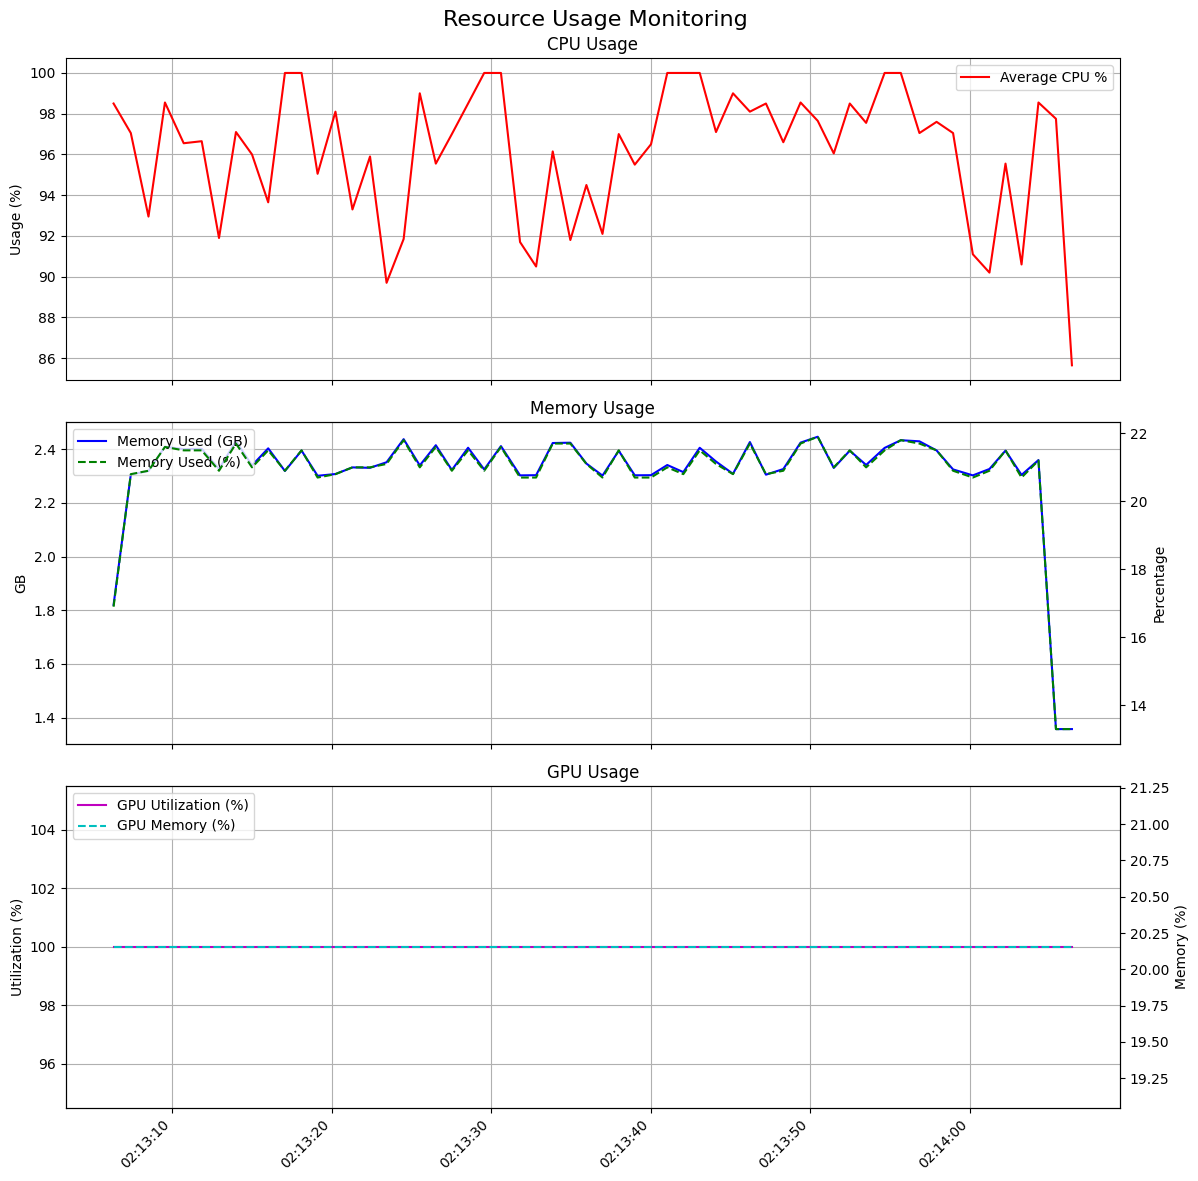

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

def plot_monitoring_data(cpu_file, memory_file, gpu_file, save_plots=False):
    """
    Plot monitoring data from CSV files

    Parameters:
        cpu_file (str): Path to CPU monitoring CSV
        memory_file (str): Path to Memory monitoring CSV
        gpu_file (str): Path to GPU monitoring CSV
        save_plots (bool): Whether to save plots as PNG files
    """
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.suptitle('Resource Usage Monitoring', fontsize=16)

    # Plot CPU data
    try:
        cpu_df = pd.read_csv(cpu_file)
        cpu_df['timestamp'] = pd.to_datetime(cpu_df['timestamp'])

        ax1.plot(cpu_df['timestamp'], cpu_df['cpu_avg'], 'r-', label='Average CPU %')
        ax1.set_title('CPU Usage')
        ax1.set_ylabel('Usage (%)')
        ax1.legend()
        ax1.grid(True)

        # Format x-axis
        ax1.xaxis.set_tick_params(rotation=45)
        fig.autofmt_xdate()
    except Exception as e:
        print(f"Error plotting CPU data: {e}")

    # Plot Memory data
    try:
        mem_df = pd.read_csv(memory_file)
        mem_df['timestamp'] = pd.to_datetime(mem_df['timestamp'])

        # Create twin axes for GB and %
        ax2a = ax2
        ax2b = ax2.twinx()

        ax2a.plot(mem_df['timestamp'], mem_df['mem_used_gb'], 'b-', label='Memory Used (GB)')
        ax2b.plot(mem_df['timestamp'], mem_df['mem_percent'], 'g--', label='Memory Used (%)')

        ax2a.set_title('Memory Usage')
        ax2a.set_ylabel('GB')
        ax2b.set_ylabel('Percentage')

        # Combine legends
        lines, labels = ax2a.get_legend_handles_labels()
        lines2, labels2 = ax2b.get_legend_handles_labels()
        ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

        ax2a.grid(True)
        ax2.xaxis.set_tick_params(rotation=45)
    except Exception as e:
        print(f"Error plotting Memory data: {e}")

    # Plot GPU data
    try:
        gpu_df = pd.read_csv(gpu_file)
        gpu_df['timestamp'] = pd.to_datetime(gpu_df['timestamp'])

        # Create twin axes for utilization and memory
        ax3a = ax3
        ax3b = ax3.twinx()

        ax3a.plot(gpu_df['timestamp'], gpu_df['gpu_util'], 'm-', label='GPU Utilization (%)')
        ax3b.plot(gpu_df['timestamp'], gpu_df['gpu_mem_percent'], 'c--', label='GPU Memory (%)')

        ax3a.set_title('GPU Usage')
        ax3a.set_ylabel('Utilization (%)')
        ax3b.set_ylabel('Memory (%)')

        # Combine legends
        lines, labels = ax3a.get_legend_handles_labels()
        lines2, labels2 = ax3b.get_legend_handles_labels()
        ax3a.legend(lines + lines2, labels + labels2, loc='upper left')

        ax3a.grid(True)
        ax3.xaxis.set_tick_params(rotation=45)
    except Exception as e:
        print(f"Error plotting GPU data: {e}")

    plt.tight_layout()

    if save_plots:
        # Create plots directory if it doesn't exist
        os.makedirs("monitoring_plots", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_filename = f"monitoring_plots/resource_usage_{timestamp}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {plot_filename}")

    plt.show()

def find_latest_monitoring_files(directory="monitoring_data"):
    """
    Find the most recent monitoring files in the specified directory

    Returns:
        tuple: (cpu_file, memory_file, gpu_file) paths
    """
    try:
        # Get all relevant files
        cpu_files = [f for f in os.listdir(directory) if f.startswith("monitoring_data_cpu")]
        memory_files = [f for f in os.listdir(directory) if f.startswith("monitoring_data_memory")]
        gpu_files = [f for f in os.listdir(directory) if f.startswith("monitoring_data_gpu")]

        # Sort by timestamp (newest first)
        cpu_files.sort(reverse=True)
        memory_files.sort(reverse=True)
        gpu_files.sort(reverse=True)

        # Return full paths to the newest files
        return (
            os.path.join(directory, cpu_files[0]) if cpu_files else None,
            os.path.join(directory, memory_files[0]) if memory_files else None,
            os.path.join(directory, gpu_files[0]) if gpu_files else None
        )
    except Exception as e:
        print(f"Error finding monitoring files: {e}")
        return None, None, None

if __name__ == "__main__":
    # Find the most recent monitoring files
    cpu_file, memory_file, gpu_file = find_latest_monitoring_files()

    if cpu_file and memory_file and gpu_file:
        print(f"Found monitoring files:")
        print(f"- CPU: {cpu_file}")
        print(f"- Memory: {memory_file}")
        print(f"- GPU: {gpu_file}")

        # Plot the data
        plot_monitoring_data(cpu_file, memory_file, gpu_file, save_plots=True)
    else:
        print("Could not find all required monitoring files in the 'monitoring_data' directory")